In [5]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr
%matplotlib inline

/Users/Administrator/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Administrator/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [372]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
cd  USUKRUSITA_Files

/Users/isabella/Documents/GitHub/democracy/USUKRUSITA_Files


In [74]:
def get_cos_plot(country_name, n):
    """
    Return a plot three word lists' cosine
    similarity to democracy across all years, given a
    string of country abbreviation.
    """
    
    for aspect in ['growth', 'recession', 'friedman', 'marx', 'centralized', 'decentralized']:
        # read csv
        econ = pd.read_csv('{}_cos_{}.csv'.format(aspect, country_name), index_col=0)
        # clean data
        econ = clean_df(econ, aspect)
        if len(econ.columns) > 1:
            econ['Growth'] = econ[econ.columns[1]].rolling(n).mean()
            if aspect == 'growth':
                econ.drop(columns='growth', inplace=True)
        else:
            econ['rolling_avg'] = econ[econ.columns[0]].rolling(n).mean()
            
        if aspect == 'growth':
            total = econ
        else:
            total[aspect] = econ['rolling_avg']

    total = total.set_index('year')

    sns.set_style("darkgrid")
    g = sns.lineplot(data=total)
    g.figure.set_size_inches(10, 6)
    g.set_title('{}: Cosine Similiarty between Three Word List and Democracy'.format(country_name))

In [81]:
def clean_df(df, aspect):
    """
    A helper function that convert str values in a dataframe
    to float.
    """
    df['cosine_similarity']= df['cosine_similarity'].apply(lambda x: x[2:8])  
    df.replace('0.]]', 0, inplace=True)
    df.replace("", 0, inplace=True)
    df['{}'.format(aspect)] = df['cosine_similarity'].astype('float')
    df = df.sort_values(by='year')
    if aspect != 'growth':
        df.drop(columns=['cosine_similarity', 'year'], inplace=True)
    else:
        df.drop(columns=['cosine_similarity'], inplace=True)
    return df

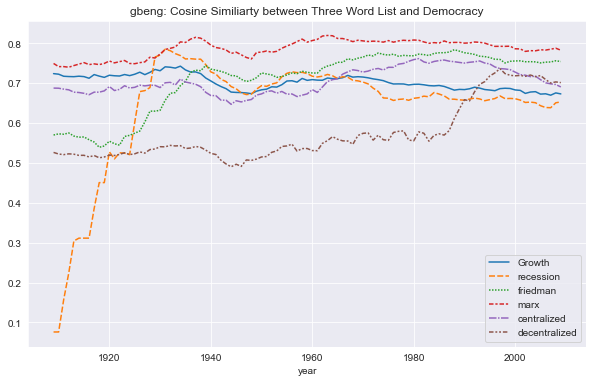

In [83]:
get_cos_plot('gbeng', 10)

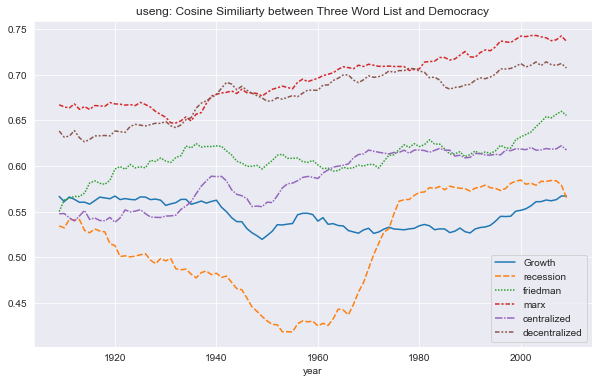

In [75]:
get_cos_plot('useng', 10)

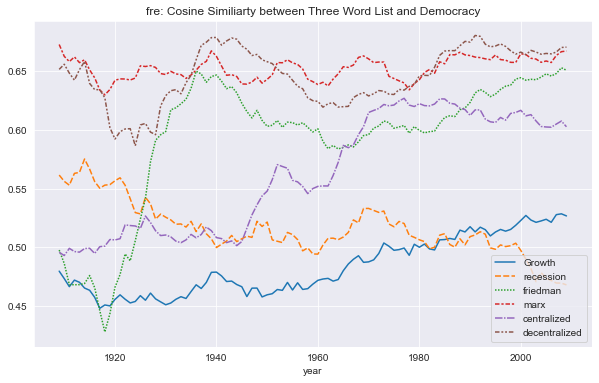

In [94]:
get_cos_plot('fre', 10)

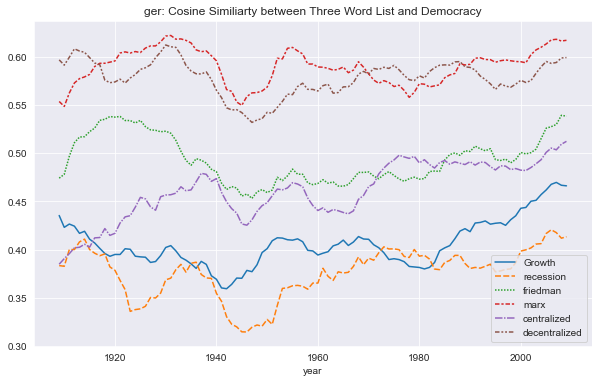

In [98]:
get_cos_plot('ger', 10)

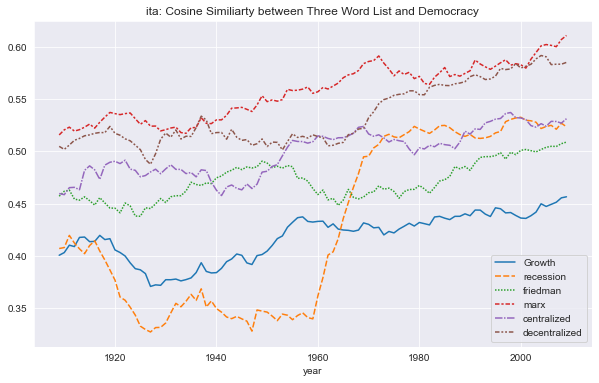

In [102]:
get_cos_plot('ita', 10)

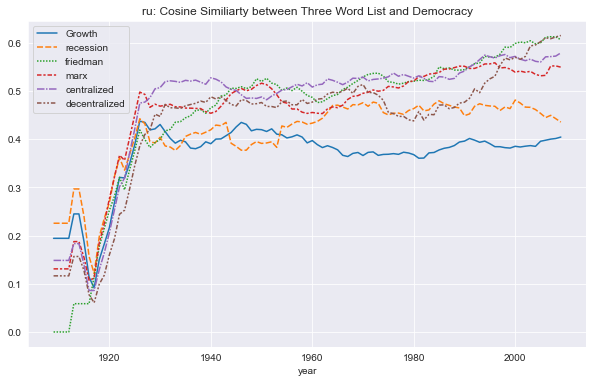

In [90]:
get_cos_plot('ru', 10)

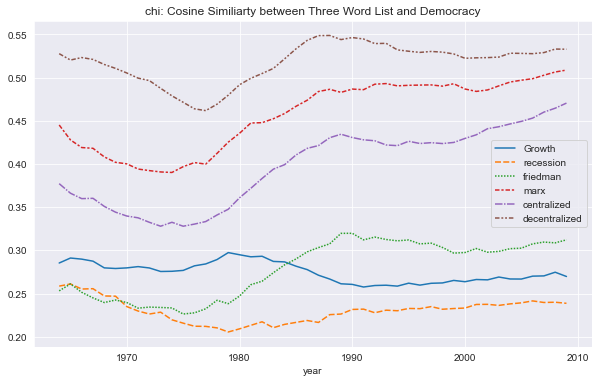

In [106]:
get_cos_plot('chi', 10)

In [223]:
def get_time_series_plot(country_name, gdp_country):
    """
    Return a plot of econ words cosine similarity
    and GDP.
    """
    for aspect in ['growth', 'recession']:
        # read csv
        econ = pd.read_csv('{}_cos_{}.csv'.format(aspect, country_name), index_col=0)
        # clean data
        econ = clean_df(econ, aspect)
        if aspect == 'growth':
            total = econ
        else:
            total[aspect] = econ[aspect]

    total = total.set_index('year')
    data = pd.read_csv('../{}'.format(gdp_country))
    time_series = total.merge(data, on='year', how='right')
    time_series.set_index('year', inplace=True)
    
    fig, ax = plt.subplots()
    ax.plot(time_series['GDP per capita growth (annual %)'], color='red', label='GDP')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    ax2 = ax.twinx()
    ax2.plot(time_series['growth'], color='green', label='growth cosine')
#     ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend()
    ax3 = ax.twinx()
    ax3.plot(time_series['recession'], color='blue', label='recession cosine')
#     ax3.tick_params(axis='y', labelcolor='blue')
    ax3.legend()
    custom_ylim = (0.4, 0.8)
    plt.setp(ax2, ylim=custom_ylim )
    plt.setp(ax3, ylim=custom_ylim)
    
    plt.legend()
    plt.title('{}: Time Series: GDP per capital growth and Cosine Simiarlity with Growth & Recession Words'.format(country_name))
    plt.show()
    

In [224]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/America

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/America


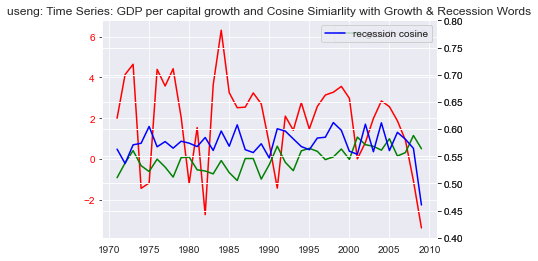

In [225]:
get_time_series_plot('useng', 'engus')

In [215]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/Great Britain

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/Great Britain


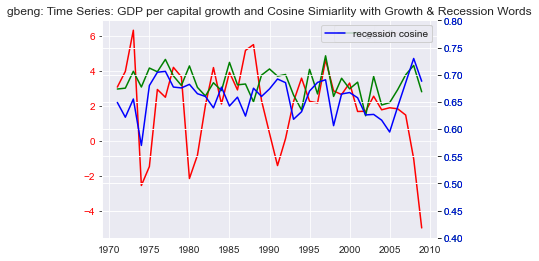

In [216]:
get_time_series_plot('gbeng','enggb')

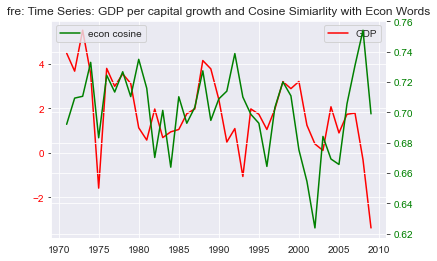

In [347]:
get_time_series_plot('fre')

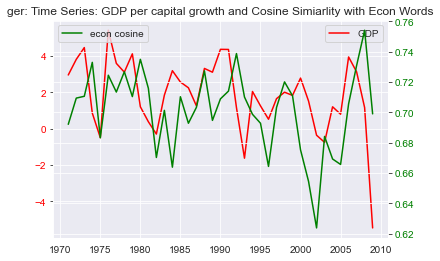

In [348]:
get_time_series_plot('ger')

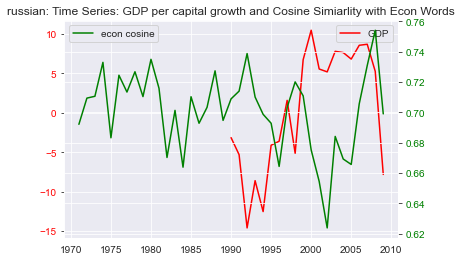

In [349]:
get_time_series_plot('russian')

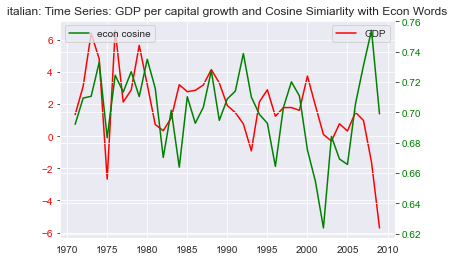

In [350]:
get_time_series_plot('italian')

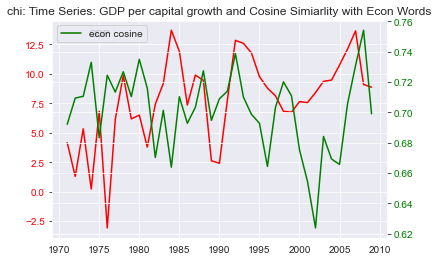

In [352]:
get_time_series_plot('chi')

In [277]:
def get_gc_test(country_name, gdp_country, inverse=True, maxlag=5):
    """
    Produce granger causality test results between 
    econ words cosine similarity and GDP.
    By default, test whether econ cosine causes GDP growths.
    If inverse=True, test whether GDP growth causes econ cosine.
    """
    
    for aspect in ['growth', 'recession', 'friedman', 'marx', 'centralized', 'decentralized']:
        # read csv
        econ = pd.read_csv('{}_cos_{}.csv'.format(aspect, country_name), index_col=0)
        # clean data
        econ = clean_df(econ, aspect)
        if aspect == 'growth':
            total = econ
        else:
            total[aspect] = econ[aspect]
            
    total = total.set_index('year')
    data = pd.read_csv('../{}'.format(gdp_country))
    time_series = total.merge(data, on='year', how='right')
    time_series.set_index('year', inplace=True)
    index = []
    cols = []
    country = pd.DataFrame(index = [1,2,3,4,5])
    for aspect in ['growth', 'recession', 'friedman', 'marx', 'centralized', 'decentralized']:
        time_series_1 = time_series.loc[:, ['GDP per capita growth (annual %)', aspect]].dropna()
        
        a1=np.array(time_series_1['GDP per capita growth (annual %)'].pct_change().dropna())
        a2=np.array(time_series_1[aspect].pct_change().dropna())
        if country_name == 'ru':
            a2=np.array(time_series[aspect].pct_change().dropna())[19:]
        
        df = pd.DataFrame(index = [1, 2, 3, 4, 5], columns = ['ssr_ftest_'+aspect, 'ssr_chi2test_'+aspect,
                                                              'lrtest_'+aspect, 'params_ftest_'+aspect])
        if inverse:
            for i, j in grangercausalitytests(np.vstack((a2, a1)).T, maxlag=maxlag).items(): 
                row = []
                for k in j[0].values():
                    row.append((k[0].round(3), k[1].round(3)))
                df.loc[i] = row
        else:
            grangercausalitytests(np.vstack((a1, a2)).T, maxlag=maxlag)
            
        country = pd.concat([country, df], axis = 1)
    
#     country=country
    country.to_csv('./{} causality_inverse'.format(country_name))
#     return None

In [296]:
get_gc_test('ru', 'russian')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2128  , p=0.6512  , df_denom=15, df_num=1
ssr based chi2 test:   chi2=0.2554  , p=0.6133  , df=1
likelihood ratio test: chi2=0.2536  , p=0.6146  , df=1
parameter F test:         F=0.2128  , p=0.6512  , df_denom=15, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8977  , p=0.4332  , df_denom=12, df_num=2
ssr based chi2 test:   chi2=2.5434  , p=0.2804  , df=2
likelihood ratio test: chi2=2.3702  , p=0.3057  , df=2
parameter F test:         F=0.8977  , p=0.4332  , df_denom=12, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6847  , p=0.5835  , df_denom=9, df_num=3
ssr based chi2 test:   chi2=3.6518  , p=0.3016  , df=3
likelihood ratio test: chi2=3.2893  , p=0.3491  , df=3
parameter F test:         F=0.6847  , p=0.5835  , df_denom=9, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6122  , p=0.6696  , df_den

In [295]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/russia

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/Russia


In [242]:
get_gc_test('useng', 'engus')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1171  , p=0.7343  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.1275  , p=0.7211  , df=1
likelihood ratio test: chi2=0.1272  , p=0.7213  , df=1
parameter F test:         F=0.1171  , p=0.7343  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6564  , p=0.2073  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=3.8472  , p=0.1461  , df=2
likelihood ratio test: chi2=3.6552  , p=0.1608  , df=2
parameter F test:         F=1.6564  , p=0.2073  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6334  , p=0.5996  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=2.3754  , p=0.4982  , df=3
likelihood ratio test: chi2=2.2983  , p=0.5128  , df=3
parameter F test:         F=0.6334  , p=0.5996  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6020  , p=0.2049  , df_d

In [127]:
get_gc_test('gbeng', 'enggb')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5882  , p=0.1169  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=2.8165  , p=0.0933  , df=1
likelihood ratio test: chi2=2.7145  , p=0.0994  , df=1
parameter F test:         F=2.5882  , p=0.1169  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7325  , p=0.0161  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=10.9915 , p=0.0041  , df=2
likelihood ratio test: chi2=9.5921  , p=0.0083  , df=2
parameter F test:         F=4.7325  , p=0.0161  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0783  , p=0.0436  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=11.5437 , p=0.0091  , df=3
likelihood ratio test: chi2=9.9766  , p=0.0188  , df=3
parameter F test:         F=3.0783  , p=0.0436  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0919  , p=0.0338  , df_d

In [129]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/French/

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/French


In [130]:

get_gc_test('fre', 'fre')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0066  , p=0.3228  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=1.0954  , p=0.2953  , df=1
likelihood ratio test: chi2=1.0795  , p=0.2988  , df=1
parameter F test:         F=1.0066  , p=0.3228  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7017  , p=0.5035  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=1.6297  , p=0.4427  , df=2
likelihood ratio test: chi2=1.5938  , p=0.4507  , df=2
parameter F test:         F=0.7017  , p=0.5035  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8181  , p=0.4948  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=3.0680  , p=0.3813  , df=3
likelihood ratio test: chi2=2.9409  , p=0.4008  , df=3
parameter F test:         F=0.8181  , p=0.4948  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6589  , p=0.6263  , df_d

In [131]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/german/

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/german


In [132]:
get_gc_test('ger', 'ger')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0836  , p=0.7743  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.0909  , p=0.7630  , df=1
likelihood ratio test: chi2=0.0908  , p=0.7631  , df=1
parameter F test:         F=0.0836  , p=0.7743  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9810  , p=0.3863  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=2.2784  , p=0.3201  , df=2
likelihood ratio test: chi2=2.2092  , p=0.3313  , df=2
parameter F test:         F=0.9810  , p=0.3863  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9691  , p=0.4211  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=3.6342  , p=0.3038  , df=3
likelihood ratio test: chi2=3.4577  , p=0.3263  , df=3
parameter F test:         F=0.9691  , p=0.4211  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7149  , p=0.5896  , df_d

In [133]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/italian_word_list/

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/italian_word_list


In [134]:
get_gc_test('ita', 'italian')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9394  , p=0.1728  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=2.1105  , p=0.1463  , df=1
likelihood ratio test: chi2=2.0525  , p=0.1520  , df=1
parameter F test:         F=1.9394  , p=0.1728  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9609  , p=0.3936  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=2.2319  , p=0.3276  , df=2
likelihood ratio test: chi2=2.1654  , p=0.3387  , df=2
parameter F test:         F=0.9609  , p=0.3936  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0004  , p=0.4072  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=3.7516  , p=0.2896  , df=3
likelihood ratio test: chi2=3.5638  , p=0.3126  , df=3
parameter F test:         F=1.0004  , p=0.4072  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8816  , p=0.4891  , df_d

In [135]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/chinese/

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/chinese


In [136]:
get_gc_test('chi', 'chi')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2580  , p=0.6148  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.2808  , p=0.5962  , df=1
likelihood ratio test: chi2=0.2797  , p=0.5969  , df=1
parameter F test:         F=0.2580  , p=0.6148  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2669  , p=0.7675  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=0.6198  , p=0.7335  , df=2
likelihood ratio test: chi2=0.6145  , p=0.7355  , df=2
parameter F test:         F=0.2669  , p=0.7675  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6862  , p=0.5680  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=2.5733  , p=0.4622  , df=3
likelihood ratio test: chi2=2.4831  , p=0.4784  , df=3
parameter F test:         F=0.6862  , p=0.5680  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8242  , p=0.1557  , df_d

In [137]:
cd /Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/russia/

/Users/Administrator/Desktop/UChicago/Y1Q2/CCA2022/democracy/Russia


In [145]:
get_gc_test('ru', 'russian')

[ 0.68164303  1.74761685 -0.41017324  0.45478583 -0.67122461 -0.12316865
 -1.43367092 -4.28065387 -2.30844711  0.55490371 -0.46990954 -0.06561904
  0.50267136 -0.0199632  -0.10820664  0.25685911  0.01529123 -0.39599832
 -2.49207582] [-0.04941577 -0.18514725  0.24607165 -0.08575032  0.03365517 -0.1198292
  0.21012735 -0.08494112 -0.08953998  0.01203008  0.17087667  0.07969543
 -0.04795487  0.02469136 -0.01253012 -0.15129331  0.25675676  0.00251659
 -0.19739845  0.1137333  -0.08373755  0.06185567  0.12647599 -0.15699977
 -0.03951368 -0.00201381  0.20351686  0.02946108 -0.09609121 -0.02934363
 -0.00450809  0.04741609  0.05340793  0.12844037 -0.20967052  0.00027071
  0.16508796  0.06736353]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 38 and the array at index 1 has size 19

In [38]:
get_gc_test('fre', inverse=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0685  , p=0.1595  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=2.2511  , p=0.1335  , df=1
likelihood ratio test: chi2=2.1852  , p=0.1393  , df=1
parameter F test:         F=2.0685  , p=0.1595  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2089  , p=0.3122  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=2.8078  , p=0.2456  , df=2
likelihood ratio test: chi2=2.7037  , p=0.2588  , df=2
parameter F test:         F=1.2089  , p=0.3122  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9944  , p=0.4098  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=3.7289  , p=0.2923  , df=3
likelihood ratio test: chi2=3.5433  , p=0.3152  , df=3
parameter F test:         F=0.9944  , p=0.4098  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9352  , p=0.4597  , df_d

In [40]:
get_gc_test('ger')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0852  , p=0.3049  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=1.1809  , p=0.2772  , df=1
likelihood ratio test: chi2=1.1625  , p=0.2810  , df=1
parameter F test:         F=1.0852  , p=0.3049  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4914  , p=0.6164  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=1.1414  , p=0.5651  , df=2
likelihood ratio test: chi2=1.1236  , p=0.5702  , df=2
parameter F test:         F=0.4914  , p=0.6164  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5592  , p=0.6464  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=2.0970  , p=0.5525  , df=3
likelihood ratio test: chi2=2.0366  , p=0.5648  , df=3
parameter F test:         F=0.5592  , p=0.6464  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6196  , p=0.6527  , df_d

In [39]:
get_gc_test('ger', inverse=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0096  , p=0.3221  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=1.0987  , p=0.2946  , df=1
likelihood ratio test: chi2=1.0827  , p=0.2981  , df=1
parameter F test:         F=1.0096  , p=0.3221  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3286  , p=0.2795  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=3.0857  , p=0.2138  , df=2
likelihood ratio test: chi2=2.9606  , p=0.2276  , df=2
parameter F test:         F=1.3286  , p=0.2795  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5635  , p=0.2203  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=5.8629  , p=0.1185  , df=3
likelihood ratio test: chi2=5.4206  , p=0.1435  , df=3
parameter F test:         F=1.5635  , p=0.2203  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2268  , p=0.3247  , df_d

In [55]:
get_gc_test('russian')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0256  , p=0.8749  , df_denom=15, df_num=1
ssr based chi2 test:   chi2=0.0308  , p=0.8608  , df=1
likelihood ratio test: chi2=0.0307  , p=0.8608  , df=1
parameter F test:         F=0.0256  , p=0.8749  , df_denom=15, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3511  , p=0.7109  , df_denom=12, df_num=2
ssr based chi2 test:   chi2=0.9947  , p=0.6081  , df=2
likelihood ratio test: chi2=0.9667  , p=0.6167  , df=2
parameter F test:         F=0.3511  , p=0.7109  , df_denom=12, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2498  , p=0.8595  , df_denom=9, df_num=3
ssr based chi2 test:   chi2=1.3325  , p=0.7214  , df=3
likelihood ratio test: chi2=1.2799  , p=0.7339  , df=3
parameter F test:         F=0.2498  , p=0.8595  , df_denom=9, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8943  , p=0.5214  , df_den

In [54]:
get_gc_test('russian', inverse=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0056  , p=0.9414  , df_denom=15, df_num=1
ssr based chi2 test:   chi2=0.0067  , p=0.9347  , df=1
likelihood ratio test: chi2=0.0067  , p=0.9347  , df=1
parameter F test:         F=0.0056  , p=0.9414  , df_denom=15, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7382  , p=0.4985  , df_denom=12, df_num=2
ssr based chi2 test:   chi2=2.0916  , p=0.3514  , df=2
likelihood ratio test: chi2=1.9726  , p=0.3730  , df=2
parameter F test:         F=0.7382  , p=0.4985  , df_denom=12, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0986  , p=0.0820  , df_denom=9, df_num=3
ssr based chi2 test:   chi2=16.5261 , p=0.0009  , df=3
likelihood ratio test: chi2=11.3512 , p=0.0100  , df=3
parameter F test:         F=3.0986  , p=0.0820  , df_denom=9, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3526  , p=0.1671  , df_den

In [57]:
get_gc_test('chi')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3146  , p=0.5785  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.3424  , p=0.5584  , df=1
likelihood ratio test: chi2=0.3408  , p=0.5594  , df=1
parameter F test:         F=0.3146  , p=0.5785  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2102  , p=0.8116  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=0.4881  , p=0.7834  , df=2
likelihood ratio test: chi2=0.4848  , p=0.7847  , df=2
parameter F test:         F=0.2102  , p=0.8116  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9512  , p=0.4293  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=3.5668  , p=0.3122  , df=3
likelihood ratio test: chi2=3.3966  , p=0.3344  , df=3
parameter F test:         F=0.9512  , p=0.4293  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2198  , p=0.9248  , df_d

In [56]:
get_gc_test('chi', inverse=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0022  , p=0.9628  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.0024  , p=0.9609  , df=1
likelihood ratio test: chi2=0.0024  , p=0.9609  , df=1
parameter F test:         F=0.0022  , p=0.9628  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5258  , p=0.5963  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=1.2211  , p=0.5431  , df=2
likelihood ratio test: chi2=1.2009  , p=0.5486  , df=2
parameter F test:         F=0.5258  , p=0.5963  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4705  , p=0.7053  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=1.7643  , p=0.6227  , df=3
likelihood ratio test: chi2=1.7212  , p=0.6322  , df=3
parameter F test:         F=0.4705  , p=0.7053  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9445  , p=0.4547  , df_d

In [81]:
def get_time_series_plot(country_name):
    """
    Return the pearson correlation between
    three word lists' cosine similarity and GDP.
    """
    
    for aspect in ['econ', 'ide', 'gov']:
        # read csv
        econ = pd.read_csv('{}_cos_{}.csv'.format(aspect, country_name), index_col=0)
        # clean data
        econ = clean_df(econ, aspect)
        if aspect == 'econ':
            total = econ
        else:
            total[aspect] = econ[aspect]

    total = total.set_index('year')
    data = pd.read_csv('../{}'.format(country_name))
    time_series = total.merge(data, on='year', how='right')
    time_series.set_index('year', inplace=True)
    if country_name == 'russian':
        time_series.dropna(inplace=True)
    
    corr1, p1 = pearsonr(time_series['GDP per capita growth (annual %)'], time_series['econ'])
    corr2, p2 = pearsonr(time_series['GDP per capita growth (annual %)'], time_series['gov'])
    corr3, p3 = pearsonr(time_series['GDP per capita growth (annual %)'], time_series['ide'])
    
    return pd.DataFrame({'correlation': [corr1, corr2, corr3],
                         'p-value': [p1, p2, p3]}, 
                        index=['econ', 'gov', 'ide'])

In [82]:
get_time_series_plot('enggb')

,correlation,p-value
econ,-0.118544,0.472290
gov,-0.162461,0.323083
ide,0.395298,0.012750


In [83]:
get_time_series_plot('engus')

,correlation,p-value
econ,-0.103426,0.530944
gov,-0.026339,0.873543
ide,0.195892,0.232022


In [84]:
get_time_series_plot('fre')

,correlation,p-value
econ,0.145916,0.375427
gov,-0.331233,0.039418
ide,0.076285,0.644387


In [85]:
get_time_series_plot('ger')

,correlation,p-value
econ,-0.274178,0.091205
gov,-0.274178,0.091205
ide,0.049963,0.762609


In [86]:
get_time_series_plot('russian')

,correlation,p-value
econ,0.163589,0.560189
gov,-0.092645,0.742616
ide,0.436750,0.103578


In [87]:
get_time_series_plot('italian')

,correlation,p-value
econ,0.117224,0.477270
gov,-0.287163,0.076306
ide,-0.010672,0.948586


In [88]:
get_time_series_plot('chi')

,correlation,p-value
econ,0.120683,0.464274
gov,-0.091354,0.580193
ide,0.569127,0.000156
